In [23]:
!ls data

cas_to_chembl.csv      chemical_group_8.csv	   species_groups_13.csv
cas_to_mesh.csv        chemical_group_9.csv	   species_groups_14.csv
chembl_to_cid.csv      chemicals_0.csv		   species_groups_15.csv
chembl_to_mesh.csv     chemicals_0.ttl		   species_groups_16.csv
chembl_to_smiles.csv   chemicals_1.csv		   species_groups_17.csv
chemical_group_10.csv  chemicals_1.ttl		   species_groups_18.csv
chemical_group_11.csv  chemicals_2.csv		   species_groups_19.csv
chemical_group_12.csv  chemicals_2.ttl		   species_groups_1.csv
chemical_group_13.csv  chemicals_features.csv	   species_groups_2.csv
chemical_group_14.csv  chemicals_fingerprints.csv  species_groups_3.csv
chemical_group_15.csv  cid_to_mesh.csv		   species_groups_4.csv
chemical_group_16.csv  embeddings		   species_groups_5.csv
chemical_group_17.csv  experiments.csv		   species_groups_6.csv
chemical_group_18.csv  final_mappings.txt	   species_groups_7.csv
chemical_group_19.csv  mesh_to_chembl.csv	   species_groups_8.csv
chemical_gro

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
from itertools import product
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [25]:
MIN_CONC = 1e-14
experiments = pd.read_csv('./data/experiments.csv')

experiments.drop(experiments[experiments['study_duration']!=48].index,inplace=True)
experiments['concentration'] = experiments['concentration'].apply(lambda x: np.log(x+MIN_CONC))
mean_conc = np.mean(experiments.concentration)
std_conc = np.std(experiments.concentration)
experiments.drop(experiments[experiments.concentration>mean_conc+3*std_conc].index,inplace=True)
experiments.drop(experiments[experiments.concentration<mean_conc-3*std_conc].index,inplace=True)
experiments.head()

,Unnamed: 0,chemical,species,concentration,study_duration
13,13,http://rdf.ebi.ac.uk/resource/chembl/molecule/...,https://www.ncbi.nlm.nih.gov/taxonomy/taxon/16...,0.003992,48.0
14,14,http://rdf.ebi.ac.uk/resource/chembl/molecule/...,https://www.ncbi.nlm.nih.gov/taxonomy/taxon/35525,4.812184,48.0
21,21,http://rdf.ebi.ac.uk/resource/chembl/molecule/...,https://www.ncbi.nlm.nih.gov/taxonomy/taxon/52641,-3.381395,48.0
28,28,http://rdf.ebi.ac.uk/resource/chembl/molecule/...,https://www.ncbi.nlm.nih.gov/taxonomy/taxon/7159,6.049733,48.0
30,30,http://rdf.ebi.ac.uk/resource/chembl/molecule/...,https://www.ncbi.nlm.nih.gov/taxonomy/taxon/7107,-0.884308,48.0


In [26]:
experimental_chemicals = set(experiments['chemical'])
experimental_species = set(experiments['species'])
len(experimental_chemicals),len(experimental_species)

(429, 184)

In [27]:
chemical_kg = pd.concat([pd.read_csv(f'./data/chemicals_{i}.csv') for i in range(3)])
chemical_kg.head()

,Unnamed: 0,subject,predicate,object
0,0,http://id.nlm.nih.gov/mesh/D000736,http://id.nlm.nih.gov/mesh/vocab#allowableQual...,http://id.nlm.nih.gov/mesh/Q000037
1,1,http://id.nlm.nih.gov/mesh/D058915,http://id.nlm.nih.gov/mesh/vocab#allowableQual...,http://id.nlm.nih.gov/mesh/Q000378
2,2,http://rdf.ebi.ac.uk/resource/chembl/molecule/...,http://id.nlm.nih.gov/mesh/vocab#allowableQual...,http://id.nlm.nih.gov/mesh/Q000592
3,3,http://id.nlm.nih.gov/mesh/D006176,http://id.nlm.nih.gov/mesh/vocab#seeAlso,http://id.nlm.nih.gov/mesh/D005831
4,4,http://id.nlm.nih.gov/mesh/M0012768,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://id.nlm.nih.gov/mesh/vocab#Concept


In [28]:
taxonomy_kg = pd.read_csv('./data/taxonomy.csv')
taxonomy_kg.head()

,Unnamed: 0,subject,predicate,object
0,0,https://www.ncbi.nlm.nih.gov/taxonomy/taxon/7909,http://www.w3.org/2000/01/rdf-schema#subClassOf,https://www.ncbi.nlm.nih.gov/taxonomy/taxon/12...
1,1,https://www.ncbi.nlm.nih.gov/taxonomy/taxon/29...,http://eol.org/schema/terms/Present,http://www.geonames.org/3570311
2,2,http://www.geonames.org/1210997,http://www.w3.org/2000/01/rdf-schema#subClassOf,https://www.wikidata.org/entity/Q39061
3,3,https://www.ncbi.nlm.nih.gov/taxonomy/taxon/30870,https://www.ncbi.nlm.nih.gov/taxonomy/rank,https://www.ncbi.nlm.nih.gov/taxonomy/rank/family
4,4,https://www.ncbi.nlm.nih.gov/taxonomy/taxon/7959,http://eol.org/schema/terms/IntroducedRange,http://www.geonames.org/1861060


In [29]:
chemical_features = pd.read_csv('./data/chemicals_features.csv')
chemical_features.dropna(inplace=True)
c = list(chemical_features.select_dtypes(include=['float64']).columns)
chemical_features = dict(zip(chemical_features['chemical'],chemical_features[c].values))

In [30]:
chemical_fingerprints = pd.read_csv('./data/chemicals_fingerprints.csv')
f2a = lambda x: np.asarray([int(i) for i in x])
chemical_fingerprints = dict(zip(chemical_fingerprints['chemical'],chemical_fingerprints['fingerprint'].apply(f2a)))

In [31]:
!ls data/embeddings

ComplEx_chemical_-1882636517035687140_entity_embeddings.npy
ComplEx_chemical_-1882636517035687140_entity_ids.npy
ComplEx_chemical_-1882636517035687140_relational_embeddings.npy
ComplEx_chemical_-1882636517035687140_relation_ids.npy
ComplEx_chemical_2358394570051540768_entity_embeddings.npy
ComplEx_chemical_2358394570051540768_entity_ids.npy
ComplEx_chemical_2358394570051540768_relational_embeddings.npy
ComplEx_chemical_2358394570051540768_relation_ids.npy
ComplEx_chemical_3840132825052968429_entity_embeddings.npy
ComplEx_chemical_3840132825052968429_entity_ids.npy
ComplEx_chemical_3840132825052968429_relational_embeddings.npy
ComplEx_chemical_3840132825052968429_relation_ids.npy
ComplEx_chemical_-5164621852614943976_entity_embeddings.npy
ComplEx_chemical_-5164621852614943976_entity_ids.npy
ComplEx_chemical_-5164621852614943976_relational_embeddings.npy
ComplEx_chemical_-5164621852614943976_relation_ids.npy
ComplEx_chemical_-8458139203682520985_entity_embeddings.npy
ComplEx_chemical_-84

In [32]:
chemical_embeddings = np.load('./data/embeddings/ComplEx_chemical_-1882636517035687140_entity_embeddings.npy')
chemical_ids = np.load('./data/embeddings/ComplEx_chemical_-1882636517035687140_entity_ids.npy')
chemical_embeddings = {i[0]:chemical_embeddings[int(i[1])] for e,i in zip(chemical_embeddings,chemical_ids)}

In [33]:
taxonomy_embeddings = np.load('./data/embeddings/ComplEx_taxonomy_-1882636517035687140_entity_embeddings.npy')
taxonomy_ids = np.load('./data/embeddings/ComplEx_taxonomy_-1882636517035687140_entity_ids.npy')
taxonomy_embeddings = {i[0]:taxonomy_embeddings[int(i[1])] for e,i in zip(taxonomy_embeddings,taxonomy_ids)}

In [34]:
%%time
def calculate_distances(d,_set):
    out = np.zeros((len(_set),len(_set)))
    for i,k1 in enumerate(_set):
        for j,k2 in enumerate(_set):
            if k1 == k2 or not k1 in d or not k2 in d:
                out[i,j] = float('inf')
            else:
                out[i,j] = np.linalg.norm(d[k1]-d[k2])
    return out

chemical_distances = calculate_distances(chemical_embeddings,experimental_chemicals)
species_distances = calculate_distances(taxonomy_embeddings,experimental_species)

CPU times: user 760 ms, sys: 37 ms, total: 797 ms
Wall time: 759 ms


In [35]:
count_s = {}
for s in experiments['species']:
    count_s[s] = sum((experiments['species']==s).astype(int))

test_species = sorted(count_s.items(),key=lambda x:x[1],reverse=True).pop(0)[0]
test_species

'https://www.ncbi.nlm.nih.gov/taxonomy/taxon/35525'

In [36]:

import sys
from SPARQLWrapper import SPARQLWrapper, JSON

endpoint_url = "https://query.wikidata.org/sparql"

query = """select ?from ?to where {
  [] wdt:P592 ?from ;
     wdt:P233 ?to .
}"""


def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
    # TODO adjust user agent; see https://w.wiki/CX6
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()


results = get_results(endpoint_url, query)
mapping = {}
for result in results["results"]["bindings"]:
    mapping[result['to']['value']]=result['from']['value'].split('/')[-1]

In [37]:
#epa_test = pd.read_csv('./data/test_qsar.csv').join(pd.read_csv('smiles_for_raoul.csv'))
#epa_test['SMILES'] = list(map(lambda x: 'http://rdf.ebi.ac.uk/resource/chembl/molecule/'+mapping[x],epa_test['SMILES']))
#epa_test = epa_test.merge(test_data,left_on='SMILES',right_on='chemical')
#epa_test['concentration'] = epa_test['concentration'].apply(np.exp)
#epa_test.dropna(inplace=True)

#x,y = epa_test['pred_mg_l'],epa_test['concentration']
#print(epa_test['pred_mg_l'].corr(epa_test['concentration']))

In [38]:
smiles_fingerprints = pd.read_csv('./data/smiles_fingerprints.csv')
smiles_fingerprints.head()

,Unnamed: 0,chemical,sig0,sig1,sig2,sig3,sig4,sig5,sig6,sig7,...,sig24,sig25,sig26,sig27,sig28,sig29,sig30,sig31,sig32,sig33
0,0,http://rdf.ebi.ac.uk/resource/chembl/molecule/...,0,0,0,0,0,0,0,0.0,...,0,0,0,0,0,0,0,0.0,0.0,0
1,1,http://rdf.ebi.ac.uk/resource/chembl/molecule/...,0,0,0,0,0,20,0,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
2,2,http://rdf.ebi.ac.uk/resource/chembl/molecule/...,0,0,0,0,0,3,0,0.0,...,0,0,0,0,0,0,0,0.0,0.0,0
3,3,http://rdf.ebi.ac.uk/resource/chembl/molecule/...,0,0,0,0,0,19,0,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
4,4,http://rdf.ebi.ac.uk/resource/chembl/molecule/...,0,0,0,0,0,17,0,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0


In [39]:
signals = [c for c in smiles_fingerprints.columns if 'sig' in c]
smiles_array = smiles_fingerprints[signals].values

In [40]:
#from sklearn.metrics import silhouette_score
#from sklearn.cluster import KMeans

#kmax = 15

#sil = defaultdict(list)
#for k in tqdm(range(2,kmax+1)):
#    kmeans = KMeans(n_clusters = k).fit(smiles_array)
#    labels = kmeans.labels_
#    for distance in ['cosine', 'euclidean']:
#        sil[distance].append(silhouette_score(smiles_array, labels, metric = distance))

In [41]:

#for k in sil:
#    x = np.asarray(sil[k])
#    x = (x - x.min()) / (x.max()-x.min())
#    plt.plot(np.arange(2,kmax+1),x,label=k)
#plt.legend(loc='upper right')
#plt.show()

In [42]:
k = 4
kmeans = KMeans(n_clusters = k).fit_predict(smiles_array)
clusters = defaultdict(set)
for c,p in zip(smiles_fingerprints['chemical'],kmeans):
    clusters[p].add(c)

In [44]:
test_data = experiments[experiments.species == test_species]
keep_chemicals = set(filter(lambda x: x in chemical_fingerprints,test_data.chemical))
keep_chemicals &= set(filter(lambda x: x in chemical_embeddings,test_data.chemical))
keep_chemicals &= set(filter(lambda x: x in chemical_features,test_data.chemical))

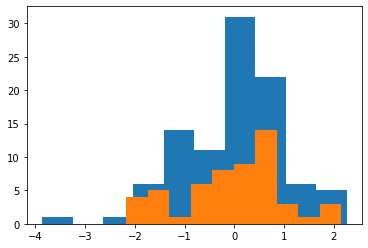

In [45]:
from sklearn.preprocessing import StandardScaler
for c in clusters:
    if len(keep_chemicals & clusters[c]) < 10: 
        continue
    data = test_data[test_data['chemical'].isin(keep_chemicals & clusters[c])]
    data = data.groupby(['chemical','species'],as_index=False).mean()
    y = data['concentration'].values
    y = StandardScaler().fit_transform(y.reshape((-1,1))).ravel()
    
    plt.hist(y)
plt.show()
    
    #data = data.groupby(['chemical','species'],as_index=False).mean()


In [82]:
from sklearn.linear_model import LinearRegression,HuberRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

from sklearn.svm import NuSVR
from sklearn.pipeline import make_pipeline

def train_and_predict(input_data, distance_matrix=None, features=None, concs=None, use_num=2):
    """
    Distance matrix = N*M, N=|input_data.chemicals|, M=|all_chemicals|
    Concs = M*1, concs of all chemicals .
    use_num, number of neighbour points to use.
    """

    predictions = []
    for train,test in LeaveOneOut().split(input_data):
        X_train, X_test = input_data[train],input_data[test]
        y_train, y_test = output_data[train],output_data[test]
        
        if distance_matrix is not None:
            d = distance_matrix[train]
            c = np.argsort(d,axis=0)[:,:use_num]
            X_train_new = features[c]
            y_train_new = concs[c]
            X_train_new = np.concatenate([X_train_new[:,i] for i in range(use_num)],axis=0)
            y_train_new = np.concatenate([y_train_new[:,i] for i in range(use_num)],axis=0)
            
            X_train = np.concatenate([X_train,X_train_new],axis=0)
            y_train = np.concatenate([y_train,y_train_new],axis=0)
            
        regr = make_pipeline(StandardScaler(), NuSVR())
        regr.fit(X_train,y_train)
        predictions.append(regr.predict(X_test))
        
    return predictions

In [90]:

idx_all = [i for i,c in enumerate(experimental_chemicals) if c in keep_chemicals]
test_data['concentration'] = StandardScaler().fit_transform(test_data['concentration'].values.reshape(-1,1)).ravel()

for c in clusters:
    if len(keep_chemicals & clusters[c]) < 10: 
        continue
    data = test_data[test_data['chemical'].isin(keep_chemicals & clusters[c])]
    data = data.groupby(['chemical','species'],as_index=False).mean()

    cs = data['chemical'].values
    idx = [i for i,c in enumerate(experimental_chemicals) if c in cs]
    
    distance_matrix = chemical_distances[idx][:,idx_all]
    
    tmp = test_data[test_data['chemical'].isin(keep_chemicals)]
    concs = tmp.groupby(['chemical','species'],as_index=False).mean()['concentration'].values
    sd = tmp.groupby(['chemical','species'],as_index=False).mean()['study_duration'].values.reshape((-1,1))
    
    features_fp = np.asarray(list(map(lambda x: chemical_fingerprints[x], keep_chemicals)))
    features_cf = np.asarray(list(map(lambda x: chemical_features[x], keep_chemicals)))
    features_ce = np.asarray(list(map(lambda x: chemical_embeddings[x], keep_chemicals)))
    features_fp = np.concatenate([features_fp,sd],axis=1)
    features_cf = np.concatenate([features_cf,sd],axis=1)
    features_ce = np.concatenate([features_ce,sd],axis=1)
    
    input_data_fp = np.asarray(list(map(lambda x: chemical_fingerprints[x], cs)))
    input_data_cf = np.asarray(list(map(lambda x: chemical_features[x], cs)))
    input_data_ce = np.asarray(list(map(lambda x: chemical_embeddings[x], cs)))

    input_data_fp = np.concatenate([input_data_fp,data['study_duration'].values.reshape((-1,1))],axis=1)
    input_data_cf = np.concatenate([input_data_cf,data['study_duration'].values.reshape((-1,1))],axis=1)
    input_data_ce = np.concatenate([input_data_ce,data['study_duration'].values.reshape((-1,1))],axis=1)

    output_data = data['concentration'].values
    
    for j, (input_data,f,label) in enumerate(zip([input_data_fp,input_data_cf,input_data_ce],
                                                    [features_fp,features_cf,features_ce],
                                                    ['Fingerprints','Features','KGE'])):
        predictions = train_and_predict(input_data,distance_matrix,f,concs,use_num=3)
        r2 = np.around(r2_score(output_data,predictions),3)
        print(f'Method: {label},',f'Cluster size: {len(keep_chemicals & clusters[c])}',r2)
    print('\t')

<ipython-input-90-5aa65fbf3f43>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['concentration'] = StandardScaler().fit_transform(test_data['concentration'].values.reshape(-1,1)).ravel()


Method: Fingerprints Cluster size: 97 -0.356
Method: Features Cluster size: 97 -0.11
Method: KGE Cluster size: 97 -0.449
	
Method: Fingerprints Cluster size: 54 -0.289
Method: Features Cluster size: 54 -0.015
Method: KGE Cluster size: 54 -0.194
	


In [ ]:

f, axs = plt.subplots(1, 3, sharey=True)
f.set_size_inches(15, 5, forward=True)
pmin,pmax = output_data.min()-1,output_data.max()+1

for j, (input_data,label) in enumerate(zip([input_data_fp,input_data_cf,input_data_ce],
                            ['Chemical FP','Chemical Features','Chemical KGE'])):
    predictions = train_and_predict(input_data)
    r2 = np.around(r2_score(output_data,predictions),3)
    m, b = np.polyfit(output_data, predictions, 1)
    axs[j].plot(output_data, predictions, 'o')
    axs[j].plot(output_data, m*output_data + b)
    axs[j].set_xlim(pmin,pmax)
    axs[j].set_ylim(pmin,pmax)
    axs[j].set_title(f'{label}, R2={r2}')
axs[0].set_ylabel('log mg/L predicted')
axs[0].set_xlabel('log mg/L true')

f.suptitle('Daphnia Magna LC50 Prediction',fontsize=16)